# Trends in Sell Side Modeling

### Codeing Assignment 4
### Group: Guoli Rao (gr2314), Shengbo Lang, Tianyi Wan

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fsolve
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [117]:
# using the model parameter from cw2
a = 0.025
b = 0.002
sigma_r = 0.02
c = 0.4
k2 = 0.05
rho_inf = 0.4

sigma_1 = c*sigma_r
v = np.sqrt(c**(-2)-1-2*(rho_inf/c-1))
sigma_2 = sigma_1*v
rho_x = (rho_inf/c-1)/v

In [118]:
lbd_a = 0.045
h_ = [0.02,0.04,0.06,0.08]

In [119]:
# simulate path for x1 and x2
def simulate_x(dt, T):
    time_span = np.linspace(0, T, T*int(1/dt)+1)
    x1 = [0]
    x2 = [0]
    
    def drift_x1(t):
        term1 = ((rho_x*sigma_1*sigma_2/k2/2)**2) * (np.exp(2*k2*t)-2*k2*t-1)
        term2 = (rho_x*sigma_1*sigma_2)/(k2**2) * \
                    (sigma_1*(np.exp(-k2*t)+k2*t-1)+sigma_2*(np.exp(k2*t)+np.exp(-k2*t)-2)/2)
        return (sigma_1*t)**2/2 + term1 + term2
    
    def drift_x2(t):
        term1 = (rho_x*sigma_1*sigma_2/(k2**2)*np.exp(-k2*t)) * \
                    (sigma_1*(np.exp(k2*t)-k2*t-1)+sigma_2*(np.exp(2*k2*t)-2*k2*t-1)/4)
        term2 = (sigma_2**2)/(2*k2*2)*np.exp(-k2*t) * ((rho_x*sigma_1)**2+1) * (np.exp(k2*t)+np.exp(-k2*t)-2)
        return term1 + term2
    
    for i in range(len(time_span)-1):
        dWt_1 = np.random.normal(0, np.sqrt(dt))
        dWt_2 = rho_x*dWt_1 + np.sqrt(1-rho_x**2)*np.random.normal(0, np.sqrt(dt))
        
        x1_diffusion = sigma_1*dWt_1
        x2_diffusion = sigma_2*np.exp(-k2*time_span[i])*dWt_2
        
        x1.append(x1[-1]+drift_x1(time_span[i+1])-drift_x1(time_span[i])+x1_diffusion)
        x2.append(x2[-1]+drift_x2(time_span[i+1])-drift_x2(time_span[i])+x2_diffusion)
        
    return x1, x2

In [184]:
# initialization
np.random.seed(99)
dt = 1/52
T = 10
num_paths = 30000
time_span_motion = np.linspace(0, T, T*int(1/dt)+1)

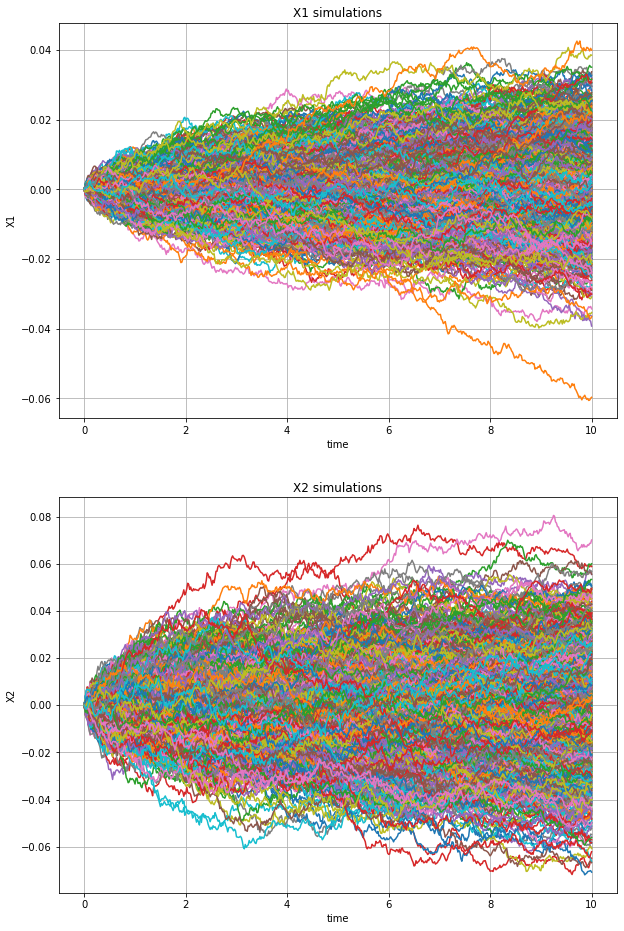

In [185]:
# 10 paths plots for x1 and x2
plt.figure(figsize=(10,16))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
ax1.set(xlabel='time', ylabel='X1', title='X1 simulations')
ax2.set(xlabel='time', ylabel='X2', title='X2 simulations')
ax1.grid()
ax2.grid()

x1s = []
x2s = []

for i in range(num_paths):
    x1, x2 = simulate_x(dt, T)
    x1s.append(x1)
    x2s.append(x2)
    ax1.plot(time_span_motion, x1)
    ax2.plot(time_span_motion, x2)

In [122]:
# build 
def y(t):
    first_layer = [t*sigma_1**2+(rho_x*sigma_1*sigma_2)**2*(np.exp(2*k2*t)-1)/(2*k2),
                  ((rho_x*sigma_1*sigma_2)/k2*(sigma_1*(np.exp(k2*t)-1)+sigma_2*(np.exp(2*k2*t)-1)/2))*np.exp(-k2*t)]
    second_layer = [first_layer[1],
                   (sigma_2**2*(np.exp(2*k2*t)-1)*((rho_x*sigma_1)**2+1)/(2*k2))*np.exp(-k2*2*t)]
    return np.array([first_layer, second_layer])

def G(t, T):
    first_layer = [T-t]
    second_layer = [-(np.exp(-k2*(T-t))-1)/k2]
    return np.array([first_layer, second_layer])

def A(t, T):
    return (-1/2)*((G(t,T).T) @ y(t) @ G(t,T))

def discount_factor(t, T):
    return np.exp(-a*(T-t) - (1/2)*b*(T-t)**2)

def F(t, T, x, dt):
    '''
    since we have done weekly spacing in Q3, and our swap makes payments semi-annually, so we need to transform
    yearly t to weekly
    '''
    discount = discount_factor(0, T)/discount_factor(0, t)
    return discount * np.exp(A(t, T)-G(t, T).T @ (x[:, int(t/dt)]))

def receiver_swap(h, x, dt, dt_4):
    '''
    params:
       h: coupon rate
       x: simulated 2-d paths
       dt: time spacing for simulation
       dt_4: time spacing for payment
    '''
    result = []
    
    time_span_motion = np.linspace(0, T, T*int(1/dt)+1)
    time_span_payment = np.linspace(0, T, T*int(1/dt_4)+1)
    for i in range(len(time_span_motion)):
        value = 0
        # as discussed in the lec, T1 should be interpreted be the first remaining payment date after tj;
        # and T0 should be interpreted as the most recent swap payment date in the past.
        # so we consider 2 cases when current time is on a payment date or somewhere in between.
        if time_span_motion[i] in time_span_payment: 
            start = time_span_motion[i]
        else:
            # most recent
            start = np.floor(time_span_motion[i] + dt_4)
        
        time_span_temp = np.arange(start, 10.00001, dt_4)
        for T_temp in time_span_temp:
            value += ((1+dt_4*h)*F(time_span_motion[i], T_temp, x, dt) - \
                      F(time_span_motion[i], T_temp-dt_4, x, dt))[0][0]

        result.append(value*notional)
    return result 

In [123]:
# as done in CD2

# 48 buckets per year
dt_bucket = 1/48
dt_semi = 1/2
notional = 5e7
T = 10
h_list = [.02, .04, .06, .08]

# num_simulation = 30000
num_simulation = 30000

In [124]:
time_span_bucket = np.linspace(0, T, int(T/(dt_bucket))+1)

# simulate paths
x1s = []
x2s = []
for i in range(num_simulation):
    x1, x2 = simulate_x(dt_bucket, T)
    x1s.append(x1)
    x2s.append(x2)

# store the swaps values in two dimension: (h, (path, time))
receiver_swap_values_h = []
payer_swap_values_h = []
EE_payer_h = []
EE_receiver_h = []

for h in h_list:
    receiver_swap_values = []
    payer_swap_values = []

    for i in range(num_simulation):
        receiver_swap_value = receiver_swap(h, np.array([x1s[i], x2s[i]]), dt_bucket, dt_semi)
        
        receiver_swap_values.append(receiver_swap_value)
        payer_swap_values.append([-v for v in receiver_swap_value])
        
    receiver_swap_values_h.append(receiver_swap_values)
    payer_swap_values_h.append(payer_swap_values)  
    
    EE_receiver_h.append(np.mean(np.clip(np.array(receiver_swap_values), a_min = 0, a_max = None), axis=0))
    EE_payer_h.append(np.mean(np.clip(np.array(payer_swap_values), a_min = 0, a_max = None), axis=0))

In [125]:
discounting_factor = np.array([discount_factor(0, t) for t in time_span_bucket])
lambda_a = 0.045
lambda_b = 0.02

# time 0 survival probability for A and B, denoted XA(0,t) and XB(0,t)
def x_a(t, T):
    return np.exp(-lambda_a * (T-t))

def x_b(t, T):
    return np.exp(-lambda_b * (T-t))

ra = 0.4
rb = 0.4
xa = np.array([x_a(0, t) for t in time_span_bucket])
xb = np.array([x_b(0, t) for t in time_span_bucket])
# cva
cva_payer_none = []
cva_receiver_none = []

for i in range(len(receiver_swap_values_h)):
    payer_temp = np.mean(np.clip(payer_swap_values_h[i], a_min = 0, a_max = None), axis=0)*discounting_factor
    cva_payer_none.append(-(1-ra) * np.sum(payer_temp * np.hstack([0, np.diff(xa)])))
    
    receiver_temp = np.mean(np.clip(receiver_swap_values_h[i], a_min = 0, a_max = None), axis=0)*discounting_factor
    cva_receiver_none.append(-(1-ra) * np.sum(receiver_temp * np.hstack([0, np.diff(xa)])))

## P1Q1 
EPE(1), EEPE(1), EAD, M

In [126]:
alpha = 1.4 # reasonable, lec note
EPE_p,EPE_r,EEs_p,EEs_r,EEPE_p,EEPE_r,M_p,M_r  = [],[],[],[],[],[],[],[]
# EE* moving max among two
rb = 0.4 # recovery rate not given

def EES(l):
    s = pd.Series(l)
    return s.cummax().values

for i in range(len(EE_payer_h)):
    EPE_p.append(EE_payer_h[i][:52].mean())
    EPE_r.append(EE_receiver_h[i][:52].mean())

    EEs_p.append(EES(EE_payer_h[i][:52]))
    EEs_r.append(EES(EE_receiver_h[i][:52]))
    
    EEPE_p.append(EEs_p[i][:52].mean())
    EEPE_r.append(EEs_r[i][:52].mean())
    
    n = len(EE_payer_h[i])
    M_p.append(max(1, min(5, 1 + np.sum(EE_payer_h[i][52:]*discounting_factor[52:])/np.sum(EEs_p[i][:52]* discounting_factor[:52]))))
    M_r.append(max(1, min(5, 1 + np.sum(EE_receiver_h[i][52:]*discounting_factor[52:])/np.sum(EEs_r[i][:52]* discounting_factor[:52]))))
# eqn 6     
EAD_p = 1.06 * np.maximum(alpha * np.array(EEPE_p) - np.array(cva_payer_none), 0)
EAD_r = 1.06 * np.maximum(alpha * np.array(EEPE_r) - np.array(cva_receiver_none), 0)

In [127]:
data_pay = {'h':h_list,'EPE(1)':EPE_p,'EEPE(1)':EEPE_p,'EAD':EAD_p,'M':M_p }
cap_pay = pd.DataFrame(data=data_pay)
print('Capital for Payer ')
cap_pay

Capital for Payer 


,h,EPE(1),EEPE(1),EAD,M
0,0.02,6.973081e+06,7.197277e+06,9.506841e+06,5
1,0.04,1.090592e+06,1.103243e+06,1.129015e+06,5
2,0.06,6.723417e+04,7.468503e+04,0.000000e+00,5
3,0.08,1.350303e+03,1.375778e+03,0.000000e+00,5


In [128]:
data_rec = {'h':h_list,'EPE(1)':EPE_r,'EEPE(1)':EEPE_r,'EAD':EAD_r,'M':M_r }
cap_rec = pd.DataFrame(data=data_rec)
print('Capital for Receiver ')
cap_rec

Capital for Receiver 


,h,EPE(1),EEPE(1),EAD,M
0,0.02,3.207828e+05,3.378302e+05,2.247855e+05,5.000000
1,0.04,2.998942e+06,3.211509e+06,4.056518e+06,5.000000
2,0.06,1.053623e+07,1.163394e+07,1.575348e+07,5.000000
3,0.08,1.903100e+07,2.063920e+07,2.814316e+07,4.655161


## P1Q2
transition function k, regulatory AIRB capital for 8 swaps,

In [129]:
PD = 0.005
LGD = 0.6

In [130]:
def trans_k(M,p):
    def b(p):
        return (0.11852-0.05478 * np.log(p) )**2
    return (1 + (M - 2.5) * b(p)) / (1 - 1.5 * b(p))

def RegCap_AIRB(I,p,M):
    
    def rho(p):
        return 0.24 - 0.12*(1-np.exp(-50*p))
    le = I
    m_up = norm.ppf(p) - np.sqrt(rho(p))*norm.ppf(0.001)
    m_in = m_up/(np.sqrt(1-rho(p)))
    mid = norm.cdf(m_in) - p 
    ri = trans_k(M,p)
    return le*mid*ri

In [131]:
k_p, k_r, RC_p, RC_r = [],[],[],[]
for i in range(4):
    k_p.append(trans_k(M_p[i],PD))
    k_r.append(trans_k(M_r[i],PD))
    RC_p.append(RegCap_AIRB(LGD,PD,M_p[i])*EAD_p[i])
    RC_r.append(RegCap_AIRB(LGD,PD,M_r[i])*EAD_r[i])

In [132]:
RC_pay = {'h':h_list,'Transition Function k':k_p,'Credit risk capital':RC_p}
RC_pay = pd.DataFrame(data=RC_pay)
print('Credit risk Capital for Payer ')
RC_pay

Credit risk Capital for Payer 


,h,Transition Function k,Credit risk capital
0,0.02,1.891875,1.000775e+06
1,0.04,1.891875,1.188502e+05
2,0.06,1.891875,0.000000e+00
3,0.08,1.891875,0.000000e+00


In [133]:
RC_rec = {'h':h_list,'Transition Function k':k_r,'Credit risk capital':RC_r}
RC_rec = pd.DataFrame(data=RC_rec)
print('Credit risk Capital for Receiver ')
RC_rec

Credit risk Capital for Receiver 


,h,Transition Function k,Credit risk capital
0,0.02,1.891875,2.366294e+04
1,0.04,1.891875,4.270254e+05
2,0.06,1.891875,1.658353e+06
3,0.08,1.814987,2.842197e+06


## P1Q3  
Q1 Q2 with variation margin

In [134]:
EE_payer_collateral = []
EE_receiver_collateral = []

for i in range(len(receiver_swap_values_h)):
    # time-axis diff; simulation-axis mean
    EE_payer_collateral.append(np.mean(np.clip(pd.DataFrame(payer_swap_values_h[i]).diff(2, axis=1)\
                                               .values, a_min = 0, a_max = None), axis=0)[2:])
    EE_receiver_collateral.append(np.mean(np.clip(pd.DataFrame(receiver_swap_values_h[i]).diff(2, axis=1)\
                                                  .values, a_min = 0, a_max = None), axis=0)[2:])    


In [135]:
cva_payer_vm = []
cva_receiver_vm = []

for i in range(len(receiver_swap_values_h)):
    payer_temp = np.mean(np.clip(pd.DataFrame(payer_swap_values_h[i]).diff(2, axis=1)\
                                    .values, a_min = 0, a_max = None), axis=0)*discounting_factor
    cva_payer_vm.append(-(1-ra) * np.nansum(payer_temp * np.hstack([0, np.diff(xb)])))
    
    receiver_temp = np.mean(np.clip(pd.DataFrame(receiver_swap_values_h[i]).diff(2, axis=1)\
                                    .values, a_min = 0, a_max = None), axis=0)*discounting_factor
    cva_receiver_vm.append(-(1-ra) * np.nansum(receiver_temp * np.hstack([0, np.diff(xb)])))

In [136]:
alpha = 1.4 # reasonable, lec note
EPE_p_vm,EPE_r_vm,EEs_p_vm,EEs_r_vm,EEPE_p_vm,EEPE_r_vm,M_p_vm,M_r_vm  = [],[],[],[],[],[],[],[]
# EE* moving max among two
rb = 0.4 # recovery rate not given, using the last

for i in range(len(EE_payer_collateral)):
    EPE_p_vm.append(EE_payer_collateral[i][:52].mean())
    EPE_r_vm.append(EE_receiver_collateral[i][:52].mean())

    EEs_p_vm.append(EES(EE_payer_collateral[i][:52]))
    EEs_r_vm.append(EES(EE_receiver_collateral[i][:52]))
    
    EEPE_p_vm.append(EEs_p_vm[i][:52].mean())
    EEPE_r_vm.append(EEs_r_vm[i][:52].mean())
    
    n = len(EE_payer_collateral[i])
    M_p_vm.append(max(1, min(5, 1 + np.sum(EE_payer_collateral[i][52:]*discounting_factor[54:])/np.sum(EEs_p_vm[i][:52]* discounting_factor[2:54]))))
    M_r_vm.append(max(1, min(5, 1 + np.sum(EE_receiver_collateral[i][52:]*discounting_factor[54:])/np.sum(EEs_r_vm[i][:52]* discounting_factor[2:54]))))
# eqn 6     
EAD_p_vm = 1.06 * np.maximum(alpha * np.array(EEPE_p_vm) - np.array(cva_payer_vm), 0)
EAD_r_vm = 1.06 * np.maximum(alpha * np.array(EEPE_r_vm) - np.array(cva_receiver_vm), 0)

In [137]:
k_p_vm, k_r_vm, RC_p_vm, RC_r_vm = [],[],[],[]
for i in range(4):
    k_p_vm.append(trans_k(M_p_vm[i],PD))
    k_r_vm.append(trans_k(M_r_vm[i],PD))
    RC_p_vm.append(RegCap_AIRB(LGD,PD,M_p_vm[i])*EAD_p_vm[i])
    RC_r_vm.append(RegCap_AIRB(LGD,PD,M_r_vm[i])*EAD_r_vm[i])

In [138]:
data_pay_vm = {'h':h_list,'EPE(1)':EPE_p_vm,'EEPE(1)':EEPE_p_vm,'EAD':EAD_p_vm,'M':M_p_vm,'Transition Function k':k_p_vm,'Credit risk capital':RC_p_vm }
cap_pay_vm = pd.DataFrame(data=data_pay_vm)
print('Capital for Payer with full variation margin ')
cap_pay_vm

Capital for Payer with full variation margin 


,h,EPE(1),EEPE(1),EAD,M,Transition Function k,Credit risk capital
0,0.02,530940.046127,7.765604e+05,1.119765e+06,3.630622,1.586546,98852.508360
1,0.04,598987.425279,8.774699e+05,1.265687e+06,3.594641,1.578524,111169.396758
2,0.06,674207.595044,1.375772e+06,2.000634e+06,2.864070,1.415629,157588.675326
3,0.08,753642.471152,1.947527e+06,2.844084e+06,2.482642,1.330583,210567.930113


In [139]:
data_rec_vm = {'h':h_list,'EPE(1)':EPE_r_vm,'EEPE(1)':EEPE_r_vm,'EAD':EAD_r_vm,'M':M_r_vm,'Transition Function k':k_r_vm,'Credit risk capital':RC_r_vm }
cap_rec_vm = pd.DataFrame(data=data_rec_vm)
print('Capital for Receiver with full variation margin')
cap_rec_vm

Capital for Receiver with full variation margin


,h,EPE(1),EEPE(1),EAD,M,Transition Function k,Credit risk capital
0,0.02,523513.655677,719893.587589,1.033352e+06,4.116885,1.694968,97458.050737
1,0.04,561293.515753,797818.483342,1.148641e+06,3.789318,1.621931,103663.191565
2,0.06,606246.166442,875871.538439,1.263416e+06,3.576496,1.574478,110685.505791
3,0.08,655413.523473,953930.802461,1.377699e+06,3.436646,1.543296,118307.300217


## P1Q4
remove the cash-flow spikes

In [140]:
# a function to despike
def get_median_filtered(signal, threshold=3):
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

In [141]:
EE_payer_de = []
EE_receiver_de = []

for i in range(len(receiver_swap_values_h)):
    # time-axis diff; simulation-axis mean
    EE_payer_de.append(get_median_filtered(EE_payer_collateral[i]))
    EE_receiver_de.append(get_median_filtered(EE_receiver_collateral[i]))  


In [142]:
EPE_p_vm5,EPE_r_vm5,EEs_p_vm5,EEs_r_vm5,EEPE_p_vm5,EEPE_r_vm5,M_p_vm5,M_r_vm5  = [],[],[],[],[],[],[],[]
# EE* moving max among two
rb = 0.4 # recovery rate not given, using the last

for i in range(len(EE_payer_de)):
    EPE_p_vm5.append(EE_payer_de[i][:52].mean())
    EPE_r_vm5.append(EE_receiver_de[i][:52].mean())

    EEs_p_vm5.append(EES(EE_payer_de[i][:52]))
    EEs_r_vm5.append(EES(EE_receiver_de[i][:52]))
    
    EEPE_p_vm5.append(EEs_p_vm5[i][:52].mean())
    EEPE_r_vm5.append(EEs_r_vm5[i][:52].mean())
    
    n = len(EE_payer_de[i])
    M_p_vm5.append(max(1, min(5, 1 + np.sum(EE_payer_de[i][52:]*discounting_factor[54:])/np.sum(EEs_p_vm5[i][:52]* discounting_factor[2:54]))))
    M_r_vm5.append(max(1, min(5, 1 + np.sum(EE_receiver_de[i][52:]*discounting_factor[54:])/np.sum(EEs_r_vm5[i][:52]* discounting_factor[2:54]))))
# eqn 6     
EAD_p_vm5 = 1.06 * np.maximum(alpha * np.array(EEPE_p_vm5) - np.array(cva_payer_vm), 0)
EAD_r_vm5 = 1.06 * np.maximum(alpha * np.array(EEPE_r_vm5) - np.array(cva_receiver_vm), 0)

In [143]:
k_p_vm5, k_r_vm5, RC_p_vm5, RC_r_vm5 = [],[],[],[]
for i in range(4):
    k_p_vm5.append(trans_k(M_p_vm5[i],PD))
    k_r_vm5.append(trans_k(M_r_vm5[i],PD))
    RC_p_vm5.append(RegCap_AIRB(LGD,PD,M_p_vm5[i])*EAD_p_vm5[i])
    RC_r_vm5.append(RegCap_AIRB(LGD,PD,M_r_vm5[i])*EAD_r_vm5[i])

In [144]:
data_rec_vm5 = {'h':h_list,'EPE(1)':EPE_r_vm5,'EEPE(1)':EEPE_r_vm5,'EAD':EAD_r_vm5,'M':M_r_vm5,'Transition Function k':k_r_vm5,'Credit risk capital':RC_r_vm5 }
cap_rec_vm5 = pd.DataFrame(data=data_rec_vm5)
print('Capital for Payer with full variation margin after despike ')
cap_rec_vm5

Capital for Payer with full variation margin after despike 


,h,EPE(1),EEPE(1),EAD,M,Transition Function k,Credit risk capital
0,0.02,481540.092778,643110.872923,9.194066e+05,4.073494,1.685293,86216.606722
1,0.04,488409.800207,678615.295282,9.717437e+05,4.121334,1.695960,91701.233637
2,0.06,494853.151542,702759.346707,1.006517e+06,4.079925,1.686727,94465.644480
3,0.08,519617.080237,750903.145532,1.076406e+06,3.970977,1.662435,99570.055142


In [145]:
data_pay_vm5 = {'h':h_list,'EPE(1)':EPE_p_vm5,'EEPE(1)':EEPE_p_vm5,'EAD':EAD_p_vm5,'M':M_p_vm5,'Transition Function k':k_p_vm5,'Credit risk capital':RC_p_vm5 }
cap_pay_vm5 = pd.DataFrame(data=data_pay_vm5)
print('Capital for Payer with full variation margin after despike ')
cap_pay_vm5

Capital for Payer with full variation margin after despike 


,h,EPE(1),EEPE(1),EAD,M,Transition Function k,Credit risk capital
0,0.02,482149.088675,649375.037853,9.310222e+05,4.092368,1.689501,87523.868138
1,0.04,520779.895640,737284.276358,1.057651e+06,3.878752,1.641872,96625.010553
2,0.06,541600.823664,755626.091425,1.080337e+06,3.850033,1.635468,98312.637052
3,0.08,580019.619791,814286.459279,1.162356e+06,3.739746,1.610878,104186.051345


## P2Q5 


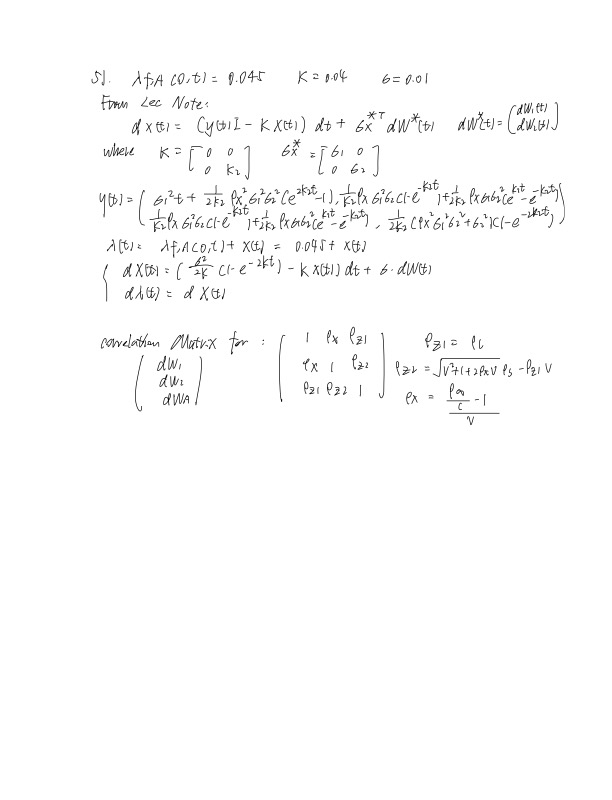笔记 2022年12月16日.pdf

In [146]:
# from last hw
hpar = 0.03472106682700023
dt = dt_bucket
T =10

sigma = 0.01
c = 0.4
rho_inf = 0.4
sigma_1 = c*sigma
v = np.sqrt(c**(-2)-1-2*(rho_inf/c-1))
sigma_2 = sigma_1*v
rho_x = (rho_inf/c-1)/v
k2 = 0.04
lbd = 0.045
# simulate path for x1 and x2

In [147]:
rho_l = 0
rho_s = 0
rhoz1 = rho_l
rhoz2 = np.sqrt(v**2+ 1 + 2*rho_x *v)*rho_s - rhoz1*v
rho_mat = np.array([[1,rho_x,rhoz1],[rho_x,1,rhoz2],[rhoz1,rhoz2,1]])
wt1 = np.linalg.cholesky(rho_mat)

In [148]:
wt1

array([[1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.2       , 0.54174243, 0.81640378]])

In [173]:

def simulate_x5(dt, T):
    time_span = np.linspace(0, T, T*int(1/dt)+1)
    y11 = lambda t: sigma_1**2 *t+ (0.5/k2)* (rho_x*sigma_1*sigma_2)**2*(np.exp(2*k2*t)-1)
    y12 = lambda t: rho_x*sigma_1**2*sigma_2*(1-np.exp(-k2*t))/k2 + (0.5/k2)*rho_x*sigma_1*sigma_2**2*(np.exp(k2*t)-np.exp(-k2*t))
    y22 = lambda t: (0.5/k2)*((rho_x*sigma_1*sigma_2)**2+sigma_2**2)(1-np.exp(-2*k2*t))
    x1 = [0]
    x2 = [0]
    lbd = [0.045]
    
    def dx1(curr,t):
        return y11(t)+y12(t)
    
    def dx2(curr,t):
        return y12(t)+y22(t)-k2*curr
    
    for i in range(len(time_span)-1):
        dWt_1 = np.random.normal(0, np.sqrt(dt))
        dWt_2 = wt1[1][0]*dWt_1 + np.sqrt(1-wt1[1][0]**2)*np.random.normal(0, np.sqrt(dt_bucket))
        dWt_A = wt1[2][0]*dWt_1 + wt1[2][1]*dWt_2+ np.sqrt(1-wt1[1][0]**2-wt1[2][0]**2)*np.random.normal(0, np.sqrt(dt_bucket))
        
        lbd.append(lbd[-1] - k2 * lbd[-1] * dt_bucket + sigma * dWt_A)
        x1.append(x1[-1] + sigma_1* dWt_1)
        x2.append(x2[-1] - k2 * x2[-1] *dt + sigma_2* dWt_2)
        
    return x1, x2, lbd

In [174]:
time_span_bucket = np.linspace(0, T, int(T/(dt_bucket))+1)
n_s = 50000
# simulate paths
x1_5 = []
x2_5 = []
lbd_5 = []
for i in range(n_s):
    x1, x2, lbd = simulate_x5(dt_bucket, T)
    x1_5.append(x1)
    x2_5.append(x2)
    lbd_5.append(lbd)

# store the swaps values in two dimension: (h, (path, time))
receiver_swap_values5 = []
payer_swap_values5 = []

for i in range(n_s):
    receiver_swap_value = receiver_swap(hpar, np.array([x1_5[i], x2_5[i]]), dt_bucket, dt_semi)
    receiver_swap_values5.append(receiver_swap_value)
    payer_swap_values5.append([-v for v in receiver_swap_value])


In [175]:
receiver_E5 = np.clip(receiver_swap_values5,0,None)
payer_E5 = np.clip(payer_swap_values5,0,None)

cva_pay_5 = 0
cva_rec_5 = 0
for i in range(len(time_span_bucket)):
    pay_temp = 0
    rec_temp = 0
    for j in range(n_s):
        expo = -(np.mean(x1_5[j]+x2_5[j]+lbd_5[j])+0.025)*10
        pay_temp += payer_E5[j][i]*lbd_5[j][i]*np.exp(expo)
        rec_temp += receiver_E5[j][i]*lbd_5[j][i]*np.exp(expo)
    cva_pay_5 += pay_temp/n_s
    cva_rec_5 += rec_temp/n_s

cva_payer_5 = cva_pay_5*10*(1-ra)/len(time_span_bucket)
cva_receiver_5 = cva_rec_5*10*(1-ra)/len(time_span_bucket)
    

In [178]:
print('CVA for Q5 payer is : ',cva_payer_5)
print('CVA for Q5 receiver is : ',cva_receiver_5)

CVA for Q5 payer is :  430259.26727834303
CVA for Q5 receiver is :  73176.47075181098


## P2Q6 change parameter

In [179]:
rho_l = 0.2
rho_s = 0.4
rhoz1 = rho_l
rhoz2 = np.sqrt(v**2+ 1 + 2*rho_x *v)*rho_s - rhoz1*v
rho_mat = np.array([[1,rho_x,rhoz1],[rho_x,1,rhoz2],[rhoz1,rhoz2,1]])
wt2 = np.linalg.cholesky(rho_mat)
wt2

array([[1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.2       , 0.54174243, 0.81640378]])

In [180]:

def simulate_x6(dt, T):
    time_span = np.linspace(0, T, T*int(1/dt)+1)
    y11 = lambda t: sigma_1**2 *t+ (0.5/k2)* (rho_x*sigma_1*sigma_2)**2*(np.exp(2*k2*t)-1)
    y12 = lambda t: rho_x*sigma_1**2*sigma_2*(1-np.exp(-k2*t))/k2 + (0.5/k2)*rho_x*sigma_1*sigma_2**2*(np.exp(k2*t)-np.exp(-k2*t))
    y22 = lambda t: (0.5/k2)*((rho_x*sigma_1*sigma_2)**2+sigma_2**2)(1-np.exp(-2*k2*t))
    x1 = [0]
    x2 = [0]
    lbd = [0.045]
    
    def dx1(curr,t):
        return y11(t)+y12(t)
    
    def dx2(curr,t):
        return y12(t)+y22(t)-k2*curr
    
    for i in range(len(time_span)-1):
        dWt_1 = np.random.normal(0, np.sqrt(dt))
        dWt_2 = wt2[1][0]*dWt_1 + np.sqrt(1-wt1[1][0]**2)*np.random.normal(0, np.sqrt(dt_bucket))
        dWt_A = wt2[2][0]*dWt_1 + wt2[2][1]*dWt_2+ np.sqrt(1-wt2[1][0]**2-wt2[2][0]**2)*np.random.normal(0, np.sqrt(dt_bucket))
        
        lbd.append(lbd[-1] - k2 * lbd[-1] * dt_bucket + sigma * dWt_A)
        x1.append(x1[-1] + sigma_1* dWt_1)
        x2.append(x2[-1] - k2 * x2[-1] *dt + sigma_2* dWt_2)
        
    return x1, x2, lbd

In [181]:
time_span_bucket = np.linspace(0, T, int(T/(dt_bucket))+1)
n_s = 50000
# simulate paths
x1_6 = []
x2_6 = []
lbd_6 = []
for i in range(n_s):
    x1, x2, lbd = simulate_x6(dt_bucket, T)
    x1_6.append(x1)
    x2_6.append(x2)
    lbd_6.append(lbd)

# store the swaps values in two dimension: (h, (path, time))
receiver_swap_values6 = []
payer_swap_values6 = []

for i in range(n_s):
    receiver_swap_value = receiver_swap(hpar, np.array([x1_6[i], x2_6[i]]), dt_bucket, dt_semi)
    receiver_swap_values6.append(receiver_swap_value)
    payer_swap_values6.append([-v for v in receiver_swap_value])


In [182]:
receiver_E6 = np.clip(receiver_swap_values6,0,None)
payer_E6 = np.clip(payer_swap_values6,0,None)

cva_pay_6 = 0
cva_rec_6 = 0
for i in range(len(time_span_bucket)):
    pay_temp = 0
    rec_temp = 0
    for j in range(n_s):
        expo = -(np.mean(x1_6[j]+x2_6[j]+lbd_6[j])+0.025)*10
        pay_temp += payer_E6[j][i]*lbd_6[j][i]*np.exp(expo)
        rec_temp += receiver_E6[j][i]*lbd_6[j][i]*np.exp(expo)
    cva_pay_6 += pay_temp/n_s
    cva_rec_6 += rec_temp/n_s

cva_payer_6 = cva_pay_6*10*(1-ra)/len(time_span_bucket)
cva_receiver_6 = cva_rec_6*10*(1-ra)/len(time_span_bucket)
    

In [183]:
print('CVA for Q6 payer is : ',cva_payer_6)
print('CVA for Q6 receiver is : ',cva_receiver_6)

CVA for Q6 payer is :  304884.59658095345
CVA for Q6 receiver is :  112388.38011641262
